# Schneider Electric Hackathon - Data Science

In [1]:
import pandas as pd
import numpy as np
import requests
import os
import PyPDF2

## Importing data
### CSV data
Import csv data with different separators and join in a single dataframe.

In [2]:
csv_df = pd.read_csv("input/train1.csv")
csv_df2 = pd.read_csv("input/train2.csv", sep = ";")
csv_df = pd.concat([csv_df, csv_df2], ignore_index = True)

### JSON data

Import json data with requests and create dataframe.

In [3]:
json_file = requests.get("http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/first")
json_file2 = requests.get("http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/second")
json_file3 = requests.get("http://schneiderapihack-env.eba-3ais9akk.us-east-2.elasticbeanstalk.com/third")
json_df = pd.concat(map(pd.DataFrame.from_dict, [json_file.json(), json_file2.json(), json_file3.json()]), ignore_index = True)

### PDF data
Loop thru all pdf files in pdf directory.<br>
If it is the first pdf create dataframe and fill info from first pdf file.<br>
Otherwise just fill the data frame

In [4]:
def create_pdf_df(lines):
    pdf_columns = []
    pdf_info = []
    for i, line in enumerate(lines):
        if ":" in line or "CITY_ID" in line:
            pdf_columns.append(line.replace(":", ""));
            pdf_info.append(lines[i + 1]);
        
    df = pd.DataFrame(columns = pdf_columns)
    df_length = len(df)
    df.loc[df_length] = pdf_info
    return df;

In [5]:
def pdf_fill(lines, df):
    pdf_info = []
    for i, line in enumerate(lines):
        if ":" in line or "CITY_ID" in line:
            pdf_info.append(lines[i + 1]);
        
    df_length = len(df)
    df.loc[df_length] = pdf_info
    return df;

In [6]:
pdf_dir = "input\pdf"
i = 0

for pdf_file in os.listdir(pdf_dir):
    f = os.path.join(pdf_dir, pdf_file)
    if os.path.isfile(f):
        pdfFile = open(f, 'rb')
        reader = PyPDF2.PdfFileReader(pdfFile)
        lines = reader.getPage(0).extractText().splitlines()       
        if i == 0:
            pdf_df = create_pdf_df(lines)
            i += 1
        else:
            pdf_df = pdf_fill(lines, pdf_df)

## Cleaning and joining data

### Rename PDF columns to match CSV and JSON dataframes

In [7]:
print(csv_df.columns)
print(json_df.columns)
print(pdf_df.columns)

Index(['countryName', 'eprtrSectorName', 'EPRTRAnnexIMainActivityLabel',
       'FacilityInspireID', 'facilityName', 'City', 'targetRelease',
       'pollutant', 'reportingYear', 'MONTH', 'DAY', 'CONTINENT',
       'max_wind_speed', 'avg_wind_speed', 'min_wind_speed', 'max_temp',
       'avg_temp', 'min_temp', 'DAY WITH FOGS', 'REPORTER NAME', 'CITY ID'],
      dtype='object')
Index(['', 'CITY ID', 'CONTINENT', 'City', 'DAY', 'DAY WITH FOGS',
       'EPRTRAnnexIMainActivityCode', 'EPRTRAnnexIMainActivityLabel',
       'EPRTRSectorCode', 'FacilityInspireID', 'MONTH', 'REPORTER NAME',
       'avg_temp', 'avg_wind_speed', 'countryName', 'eprtrSectorName',
       'facilityName', 'max_temp', 'max_wind_speed', 'min_temp',
       'min_wind_speed', 'pollutant', 'reportingYear', 'targetRelease'],
      dtype='object')
Index(['nº', 'FACILITY NAME', 'FacilityInspireID', 'COUNTRY', 'CONTINENT',
       'CITY', 'EPRTRSectorCode', 'eprtrSectorName', 'MainActivityCode',
       'targetRealase', 'pollut

In [8]:
json_df.drop("", axis = 1, inplace = True)
pdf_df.drop(["nº", "emissions"], axis = 1, inplace = True)

In [9]:
pdf_df.rename(columns = {'FACILITY NAME' : 'facilityName', 'COUNTRY': 'countryName', 'CITY': 'City',
                        'MainActivityCode': 'EPRTRAnnexIMainActivityCode', 'targetRealase': 'targetRelease',
                        'YEAR': 'reportingYear', 'DAYS FOG': 'DAY WITH FOGS', 'CITY_ID': 'CITY ID'}, inplace = True)

In [10]:
print (json_df.columns.difference(csv_df.columns))
print (json_df.columns.difference(pdf_df.columns))

print (csv_df.columns.difference(json_df.columns))
print (csv_df.columns.difference(pdf_df.columns))

print (pdf_df.columns.difference(csv_df.columns))
print (pdf_df.columns.difference(json_df.columns))

Index(['EPRTRAnnexIMainActivityCode', 'EPRTRSectorCode'], dtype='object')
Index(['EPRTRAnnexIMainActivityLabel'], dtype='object')
Index([], dtype='object')
Index(['EPRTRAnnexIMainActivityLabel'], dtype='object')
Index(['EPRTRAnnexIMainActivityCode', 'EPRTRSectorCode'], dtype='object')
Index([], dtype='object')


### Fill missing columns

In [11]:
sector_code = json_df.groupby(by=["EPRTRSectorCode", "eprtrSectorName"])["CITY ID"].count().reset_index()

In [12]:
csv_df['EPRTRSectorCode'] = 0;

In [13]:
i = 0
for i in range (len(csv_df)):
    csv_df.iloc[i, 21] = sector_code[sector_code['eprtrSectorName'] == csv_df.iloc[i, 1]]['EPRTRSectorCode'].values[0]
   

In [14]:
csv_df.head(2)

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,max_wind_speed,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRSectorCode
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,...,15.118767,14.312541,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,3
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),2018,9,...,19.661550,19.368166,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,3


In [15]:
main_activity = json_df.groupby(by=["EPRTRAnnexIMainActivityCode", "EPRTRAnnexIMainActivityLabel"])["CITY ID"].count().reset_index()

In [16]:
csv_df['EPRTRAnnexIMainActivityCode'] = 0

In [17]:
i = 0
for i in range (len(csv_df)):
    try:
        csv_df.iloc[i, 22] = main_activity[main_activity['EPRTRAnnexIMainActivityLabel'] == csv_df.iloc[i, 2]]['EPRTRAnnexIMainActivityCode'].values[0]
    except:
        csv_df.iloc[i, 22] = 'error'

In [18]:
csv_df[csv_df['EPRTRAnnexIMainActivityCode'] == 'error']

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRSectorCode,EPRTRAnnexIMainActivityCode
7238,Germany,Chemical industry,Chemical installations for the production on a...,https://registry.gdi-de.org/id/de.sn.sax4inspi...,Wacker Chemie AG,Nünchritz,AIR,Carbon dioxide (CO2),2015,8,...,18.709818,23.202782,11.783017,12.273299,14.018526,1,Erica Kelly,18b077c0c0f53e9807ea115de467321a,4,error
8906,Germany,Chemical industry,Chemical installations for the production on a...,https://registry.gdi-de.org/id/de.sn.sax4inspi...,Wacker Chemie AG,Nünchritz,AIR,Carbon dioxide (CO2),2013,6,...,21.051806,27.333603,10.623629,11.993096,13.167055,2,Benjamin Mathis,18b077c0c0f53e9807ea115de467321a,4,error


In [19]:
csv_df.loc[csv_df['EPRTRAnnexIMainActivityCode'] == 'error', 'EPRTRAnnexIMainActivityCode'] = '4.(a).(vii)'

In [20]:
csv_df[csv_df['EPRTRAnnexIMainActivityCode'] == '4.(a).(vii)']

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRSectorCode,EPRTRAnnexIMainActivityCode
7238,Germany,Chemical industry,Chemical installations for the production on a...,https://registry.gdi-de.org/id/de.sn.sax4inspi...,Wacker Chemie AG,Nünchritz,AIR,Carbon dioxide (CO2),2015,8,...,18.709818,23.202782,11.783017,12.273299,14.018526,1,Erica Kelly,18b077c0c0f53e9807ea115de467321a,4,4.(a).(vii)
8906,Germany,Chemical industry,Chemical installations for the production on a...,https://registry.gdi-de.org/id/de.sn.sax4inspi...,Wacker Chemie AG,Nünchritz,AIR,Carbon dioxide (CO2),2013,6,...,21.051806,27.333603,10.623629,11.993096,13.167055,2,Benjamin Mathis,18b077c0c0f53e9807ea115de467321a,4,4.(a).(vii)


In [21]:
csv_df.head(2)

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRSectorCode,EPRTRAnnexIMainActivityCode
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,...,14.312541,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,3,3(c)(i)
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),2018,9,...,19.368166,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,3,3(c)


In [22]:
pdf_df['EPRTRAnnexIMainActivityLabel'] = 0;

In [23]:
i = 0
for i in range (len(pdf_df)):
    try:
        pdf_df.iloc[i, 22] = main_activity[main_activity['EPRTRAnnexIMainActivityCode'] == pdf_df.iloc[i, 7]]['EPRTRAnnexIMainActivityLabel'].values[0]
    except:
        pdf_df.iloc[i, 22] = 'error'

In [24]:
pdf_df[pdf_df['EPRTRAnnexIMainActivityLabel'] == 'error']

,facilityName,FacilityInspireID,countryName,CONTINENT,City,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,targetRelease,pollutant,...,max_wind_speed,min_wind_speed,avg_wind_speed,max_temp,min_temp,avg_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRAnnexIMainActivityLabel


In [25]:
pdf_df.head(2)

,facilityName,FacilityInspireID,countryName,CONTINENT,City,EPRTRSectorCode,eprtrSectorName,EPRTRAnnexIMainActivityCode,targetRelease,pollutant,...,max_wind_speed,min_wind_speed,avg_wind_speed,max_temp,min_temp,avg_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRAnnexIMainActivityLabel
0,Millerhill Recycling & Energy Recovery Centre,UK.SEPA/200002651.Facility,United Kingdom,EUROPE,"Millerhill, Dalkeith",5,Waste and wastewater management,5(b),AIR,Nitrogen oxides (NOX),...,"1,79E+15","2,2E+16","2,04E+15","1,51E+16","1,82E+15","1,71E+16",10,William Nelson,c662b4b4d859a9c224b5ac0acf221748,Installations for the incineration of non-haza...
1,Fife Ethylene Plant,UK.SEPA/200000061.Facility,United Kingdom,EUROPE,Cowdenbeath,1,Energy sector,1(c),AIR,Carbon dioxide (CO2),...,"1,52E+16","2,06E+15","1,46E+16","9,61E+15","1,33E+16","8,69E+15",19,Shawn Graham,3c563ab0d76fc84128574b5da82f769a,Thermal power stations and other combustion in...


### Merge dataframes

In [26]:
join_df = pd.concat([csv_df, json_df, pdf_df], ignore_index = True)

In [27]:
join_df.head(2)

,countryName,eprtrSectorName,EPRTRAnnexIMainActivityLabel,FacilityInspireID,facilityName,City,targetRelease,pollutant,reportingYear,MONTH,...,avg_wind_speed,min_wind_speed,max_temp,avg_temp,min_temp,DAY WITH FOGS,REPORTER NAME,CITY ID,EPRTRSectorCode,EPRTRAnnexIMainActivityCode
0,Germany,Mineral industry,Installations for the production of cement cli...,https://registry.gdi-de.org/id/de.ni.mu/062217...,Holcim (Deutschland) GmbH Werk Höver,Sehnde,AIR,Carbon dioxide (CO2),2015,10,...,14.312541,21.419106,2.864895,4.924169,9.688206,2,Mr. Jacob Ortega,7cdb5e74adcb2ffaa21c1b61395a984f,3,3(c)(i)
1,Italy,Mineral industry,Installations for the production of cement cli...,IT.CAED/240602021.FACILITY,Stabilimento di Tavernola Bergamasca,TAVERNOLA BERGAMASCA,AIR,Nitrogen oxides (NOX),2018,9,...,19.368166,21.756389,5.462839,7.864403,12.023521,1,Ashlee Serrano,cd1dbabbdba230b828c657a9b19a8963,3,3(c)


### Transform pollutant data

In [28]:
join_df.groupby(by=["pollutant"])["pollutant"].count()

pollutant
Carbon dioxide (CO2)     22979
Methane (CH4)            16729
Nitrogen oxides (NOX)    26002
Name: pollutant, dtype: int64

In [29]:
pollutants = {'Nitrogen oxides (NOX)': 0, 'Carbon dioxide (CO2)': 1, 'Methane (CH4)': 2}
join_df['pollutant'] = join_df['pollutant'].map(pollutants)

In [30]:
join_df.groupby(by=["pollutant"])["pollutant"].count()

pollutant
0    26002
1    22979
2    16729
Name: pollutant, dtype: int64

## Decision tree model

In [31]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

In [56]:
def tree_sector(turn):
    y = join_df.pollutant
    X = pd.get_dummies(join_df[['EPRTRSectorCode']], prefix="", prefix_sep="")
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
    pollutant_tree = DecisionTreeClassifier(criterion="entropy", max_depth = turn)
    pollutant_tree.fit(X_trainset, y_trainset)
    predTree = pollutant_tree.predict(X_testset)
    return metrics.f1_score(y_testset, predTree, average = 'macro')

#    print("tree_sector f1_score: ", metrics.f1_score(y_testset, predTree, average = 'micro'))

In [57]:
def tree_activity(turn):
    y = join_df.pollutant
    X = pd.get_dummies(join_df[['EPRTRAnnexIMainActivityCode']], prefix="", prefix_sep="")
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
    pollutant_tree = DecisionTreeClassifier(criterion="entropy", max_depth = turn)
    pollutant_tree.fit(X_trainset, y_trainset)
    predTree = pollutant_tree.predict(X_testset)
    return metrics.f1_score(y_testset, predTree, average = 'macro')
#    print("tree_activity f1_score: ", metrics.f1_score(y_testset, predTree, average = 'micro'))

In [58]:
def tree_both(turn):
    y = join_df.pollutant
    X = pd.get_dummies(join_df[['EPRTRSectorCode', 'EPRTRAnnexIMainActivityCode']], prefix="", prefix_sep="")
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
    pollutant_tree = DecisionTreeClassifier(criterion="entropy", max_depth = turn)
    pollutant_tree.fit(X_trainset, y_trainset)
    predTree = pollutant_tree.predict(X_testset)
    return metrics.f1_score(y_testset, predTree, average = 'macro')
    #rint("tree_both f1_score: ", metrics.f1_score(y_testset, predTree, average = 'micro'))

In [37]:
x = []
y_sec = []
y_act = []
y_both = []
for i in range(1, 10):
    x.append(i)
    y_sec.append(tree_sector(i))
    y_act.append(tree_activity(i))
    y_both.append(tree_both(i))

In [38]:
x

[1, 2, 3, 4, 5, 6, 7, 8, 9]

In [39]:
y_sec

[0.530462131588292,
 0.5639425759650992,
 0.5639425759650992,
 0.5639425759650992,
 0.5639425759650992,
 0.5639425759650992,
 0.5639425759650992,
 0.5639425759650992,
 0.5639425759650992]

In [40]:
y_act

[0.5435499416628621,
 0.5632323847207427,
 0.5721605032212246,
 0.578095672906204,
 0.5847917617815654,
 0.590625475574494,
 0.590625475574494,
 0.5932633287678182,
 0.5952924466088368]

In [41]:
y_both

[0.5435499416628621,
 0.5770303860396693,
 0.5859585045401512,
 0.5926545934155126,
 0.5926545934155126,
 0.5952924466088368,
 0.5952924466088368,
 0.5958504540151169,
 0.5951909907167858]

In [59]:
def tree_country(turn):
    y = join_df.pollutant
    X = pd.get_dummies(join_df[['countryName']], prefix="", prefix_sep="")
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
    pollutant_tree = DecisionTreeClassifier(criterion="entropy", max_depth = turn)
    pollutant_tree.fit(X_trainset, y_trainset)
    predTree = pollutant_tree.predict(X_testset)
    return metrics.f1_score(y_testset, predTree, average = 'macro')
    #rint("tree_both f1_score: ", metrics.f1_score(y_testset, predTree, average = 'micro'))

In [60]:
def tree_city(turn):
    y = join_df.pollutant
    X = pd.get_dummies(join_df[['City']], prefix="", prefix_sep="")
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
    pollutant_tree = DecisionTreeClassifier(criterion="entropy", max_depth = turn)
    pollutant_tree.fit(X_trainset, y_trainset)
    predTree = pollutant_tree.predict(X_testset)
    return metrics.f1_score(y_testset, predTree, average = 'macro')
    #rint("tree_both f1_score: ", metrics.f1_score(y_testset, predTree, average = 'micro'))

In [61]:
def tree_citycountry(turn):
    y = join_df.pollutant
    X = pd.get_dummies(join_df[['City', 'countryName']], prefix="", prefix_sep="")
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
    pollutant_tree = DecisionTreeClassifier(criterion="entropy", max_depth = turn)
    pollutant_tree.fit(X_trainset, y_trainset)
    predTree = pollutant_tree.predict(X_testset)
    return metrics.f1_score(y_testset, predTree, average = 'macro')
    #rint("tree_both f1_score: ", metrics.f1_score(y_testset, predTree, average = 'micro'))

In [62]:
def tree_all(turn):
    y = join_df.pollutant
    X = pd.get_dummies(join_df[['City', 'countryName', 'EPRTRSectorCode', 'EPRTRAnnexIMainActivityCode']], prefix="", prefix_sep="")
    X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
    pollutant_tree = DecisionTreeClassifier(criterion="entropy", max_depth = turn)
    pollutant_tree.fit(X_trainset, y_trainset)
    predTree = pollutant_tree.predict(X_testset)
    return metrics.f1_score(y_testset, predTree, average = 'macro')

In [74]:
x = []
y_country = []
y_city = []
y_cc = []
y_sec = []
y_act = []
y_both = []
y_all = []
for i in range(1, 5):
    print (i)
    x.append(i)
    y_country.append(tree_country(i))
    y_city.append(tree_city(i))
    y_cc.append(tree_citycountry(i))
    y_sec.append(tree_sector(i))
    y_act.append(tree_activity(i))
    y_both.append(tree_both(i))
    y_all.append(tree_all(i))

1
2
3
4


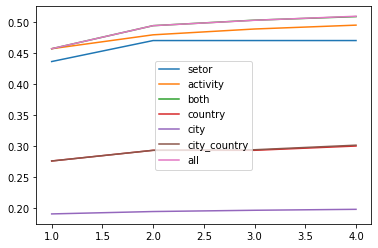

In [148]:
plt.plot(x, y_sec, label = "setor")
plt.plot(x, y_act, label = "activity")
plt.plot(x, y_both, label = "both")
plt.plot(x, y_country, label = "country")
plt.plot(x, y_city, label = "city")
plt.plot(x, y_cc, label = "city_country")
plt.plot(x, y_all, label = "all")
plt.legend()
plt.savefig('depth.png')
plt.show()


In [77]:
y = join_df.pollutant
X = pd.get_dummies(join_df[['EPRTRSectorCode', 'EPRTRAnnexIMainActivityCode']], prefix="", prefix_sep="")
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)
pollutant_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
pollutant_tree.fit(X_trainset, y_trainset)
predTree = pollutant_tree.predict(X_testset)
final_tree = metrics.f1_score(y_testset, predTree, average = 'macro')
print("Final tree f1_score: " + str(final_tree))


Final tree f1_score: 0.5090804815381954


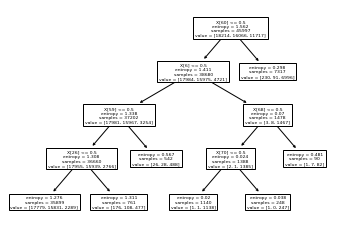

In [78]:
tree.plot_tree(pollutant_tree)
plt.show()

In [149]:
y = join_df.pollutant
X = pd.get_dummies(join_df[['EPRTRSectorCode', 'EPRTRAnnexIMainActivityCode']], prefix="", prefix_sep="")
pollutant_tree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)
pollutant_tree.fit(X, y)
predTree = pollutant_tree.predict(X)
final_tree = metrics.f1_score(y, predTree, average = 'macro')
print("Final tree with full data f1_score: " + str(final_tree))

Final tree with full data f1_score: 0.5077352830457011


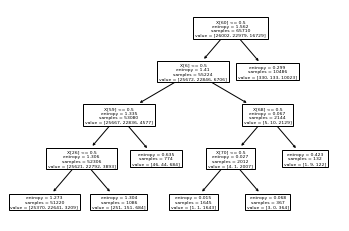

In [156]:
tree.plot_tree(pollutant_tree)
plt.savefig('tree.pdf')
plt.show()

In [93]:
test_df = pd.read_csv("input/test_x.csv")
test_df.EPRTRSectorCode = test_df.EPRTRSectorCode.astype(str)


EPRTRSectorCode
1    9163
2    1160
3    3725
4    1664
5    5901
6    1487
7     828
8     467
9      85
Name: EPRTRSectorCode, dtype: int64

In [117]:
X_test = pd.get_dummies(test_df[['EPRTRSectorCode', 'EPRTRAnnexIMainActivityCode']], prefix="", prefix_sep="")

In [119]:
feature_difference = set(X) - set(X_test)
feature_difference_df = pd.DataFrame(data=np.zeros((X_test.shape[0], len(feature_difference))),
                                     columns=list(feature_difference))
X_test = X_test.join(feature_difference_df)

In [122]:
print (X_test.columns.difference(X.columns))


Index(['4(a)(vii)'], dtype='object')


In [124]:
X_test.drop(['4(a)(vii)'], axis = 1, inplace = True)

In [125]:
result_tree = pollutant_tree.predict(X_test)

In [126]:
result_tree

array([2, 0, 0, ..., 0, 0, 0], dtype=int64)

In [134]:
df_final = pd.DataFrame(result_tree, columns = ["pollutant"])

In [138]:
df_final.reset_index(inplace = True)

In [142]:
df_final.rename(columns = {'index':'test_index'}, inplace = True)

In [143]:
df_final

,test_index,pollutant
0,0,2
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
24475,24475,0
24476,24476,0
24477,24477,0
24478,24478,0


In [145]:
df_final.to_json('predictions.json')

In [146]:
df_final.to_csv('predictions.csv')